# Alzheimer's Disease Detection from Brain MRI Scans

## Deep Learning Classification using EfficientNet

**Author:** Hack4Health Team  
**Date:** December 2025

---

### Overview

This notebook implements an AI model for early detection of Alzheimer's disease using brain MRI scans. We use transfer learning with EfficientNet-B0 to classify MRI images into four categories:

1. **NonDemented** - Healthy brain with no signs of dementia
2. **VeryMildDemented** - Very early stage Alzheimer's
3. **MildDemented** - Mild cognitive impairment
4. **ModerateDemented** - Moderate stage Alzheimer's

### Key Features
- Transfer learning with pre-trained EfficientNet-B0
- Data augmentation for improved generalization
- Weighted loss function to handle class imbalance
- Grad-CAM visualizations for model interpretability
- Comprehensive evaluation metrics

In [1]:
# Install dependencies if running in Google Colab
from google.colab import drive
drive.mount('/content/drive')
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q torch torchvision
    !pip install -q opencv-python-headless
    print("Dependencies installed!")

Mounted at /content/drive
Dependencies installed!


## 1. Setup and Imports

In [2]:
# Core imports
import os
import sys
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Progress bar
from tqdm.auto import tqdm

# OpenCV for Grad-CAM
import cv2

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True
MPS available: False


In [3]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Select device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Configuration

In [11]:
# Configuration
class Config:
    # Paths
    DATA_DIR = '/content/drive/MyDrive/Alzheimer_MRI_4_classes_dataset'
    SAVE_DIR = '/checkpoints'

    # Model
    MODEL_NAME = 'efficientnet'  # 'efficientnet', 'resnet', or 'baseline'
    NUM_CLASSES = 4
    PRETRAINED = True

    # Training
    BATCH_SIZE = 32
    NUM_EPOCHS = 20
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4

    # Data
    IMAGE_SIZE = 224
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15
    NUM_WORKERS = 0  # Set to 0 for compatibility

    # Early stopping
    PATIENCE = 7

    # Class names
    CLASS_NAMES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

config = Config()

# Create save directory
os.makedirs(config.SAVE_DIR, exist_ok=True)

print("Configuration loaded!")
print(f"Data directory: {config.DATA_DIR}")
print(f"Model: {config.MODEL_NAME}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Epochs: {config.NUM_EPOCHS}")

Configuration loaded!
Data directory: /content/drive/MyDrive/Alzheimer_MRI_4_classes_dataset
Model: efficientnet
Batch size: 32
Epochs: 20


## 3. Data Loading and Exploration

In [12]:
# Load dataset paths and labels
def load_dataset(data_dir):
    """Load all image paths and labels from the dataset directory."""
    image_paths = []
    labels = []
    class_to_idx = {name: idx for idx, name in enumerate(config.CLASS_NAMES)}

    data_path = Path(data_dir)

    for class_name in config.CLASS_NAMES:
        class_dir = data_path / class_name
        if not class_dir.exists():
            print(f"Warning: {class_dir} does not exist")
            continue

        class_idx = class_to_idx[class_name]

        for img_file in class_dir.iterdir():
            if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                image_paths.append(str(img_file))
                labels.append(class_idx)

    return image_paths, labels

# Load data
image_paths, labels = load_dataset(config.DATA_DIR)
print(f"Total images found: {len(image_paths)}")

# Class distribution
unique, counts = np.unique(labels, return_counts=True)
print("\nClass distribution:")
for idx, count in zip(unique, counts):
    print(f"  {config.CLASS_NAMES[idx]}: {count} images ({100*count/len(labels):.1f}%)")

Total images found: 6400

Class distribution:
  MildDemented: 896 images (14.0%)
  ModerateDemented: 64 images (1.0%)
  NonDemented: 3200 images (50.0%)
  VeryMildDemented: 2240 images (35.0%)


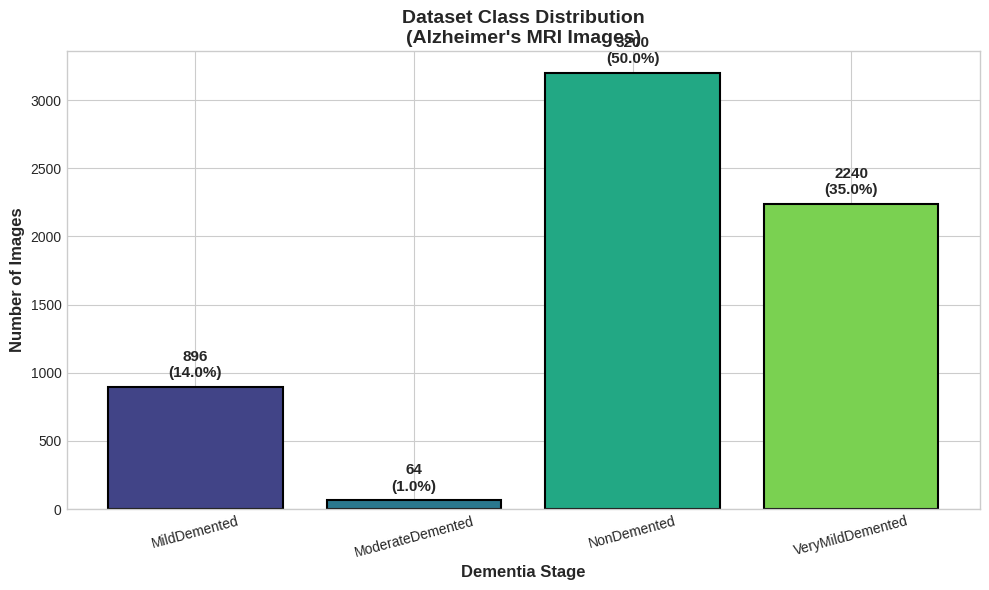


⚠️ Note: Significant class imbalance detected (ModerateDemented has very few samples)
   We will use weighted loss and weighted sampling to address this.


In [13]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(config.CLASS_NAMES)))

bars = ax.bar(config.CLASS_NAMES, counts, color=colors, edgecolor='black', linewidth=1.5)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.annotate(f'{count}\n({100*count/len(labels):.1f}%)',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), textcoords='offset points',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Dementia Stage', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title('Dataset Class Distribution\n(Alzheimer\'s MRI Images)', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=15)
plt.tight_layout()
plt.savefig('../checkpoints/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n⚠️ Note: Significant class imbalance detected (ModerateDemented has very few samples)")
print("   We will use weighted loss and weighted sampling to address this.")

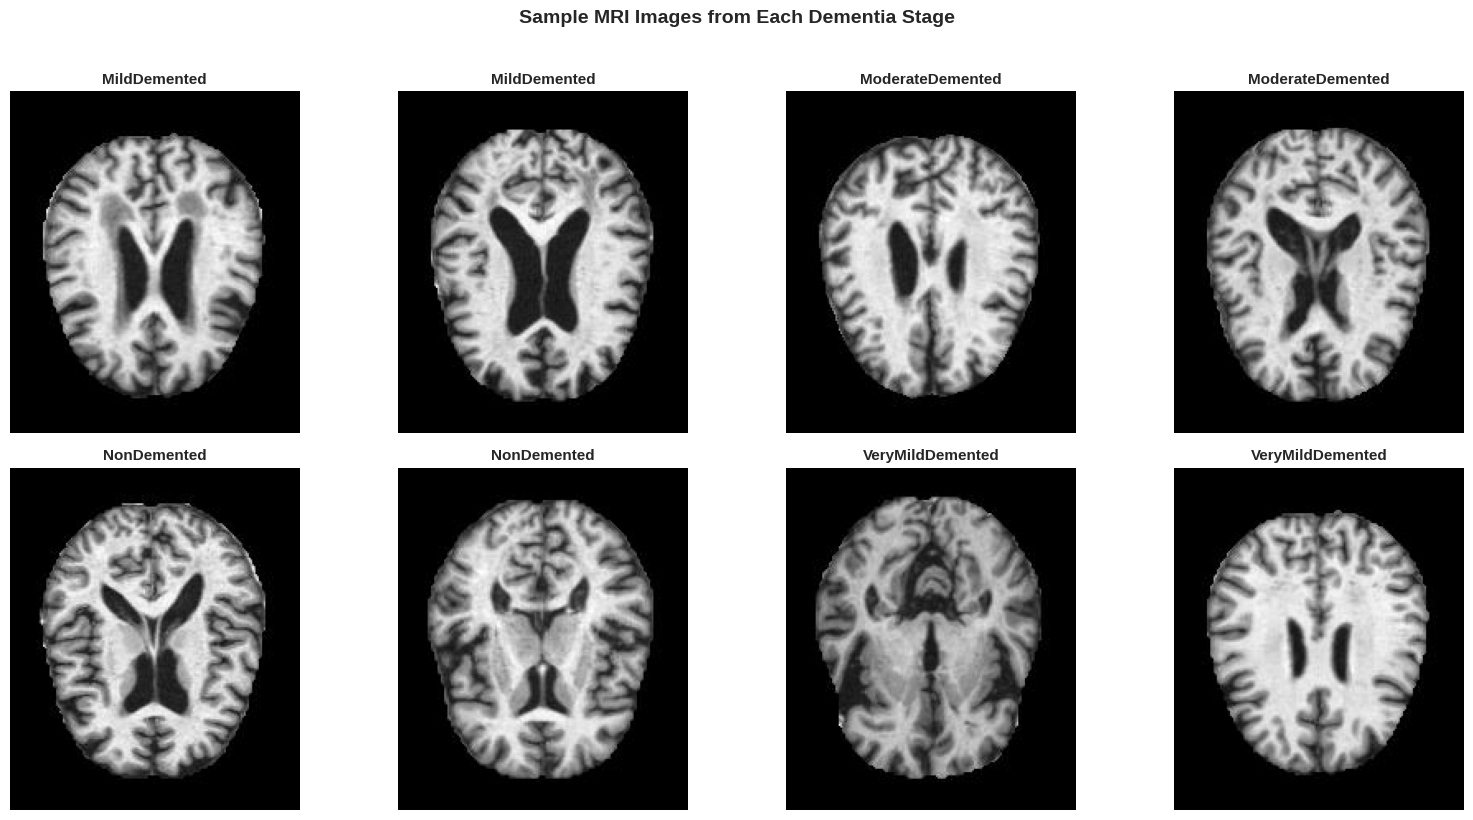

In [14]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

samples_per_class = 2
idx = 0

for class_idx, class_name in enumerate(config.CLASS_NAMES):
    class_images = [p for p, l in zip(image_paths, labels) if l == class_idx]

    for i in range(min(samples_per_class, len(class_images))):
        img = Image.open(class_images[i]).convert('RGB')
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f'{class_name}', fontsize=11, fontweight='bold')
        axes[idx].axis('off')
        idx += 1

plt.suptitle('Sample MRI Images from Each Dementia Stage', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../checkpoints/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Data Preprocessing and Augmentation

In [15]:
# ImageNet normalization values (for pre-trained models)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Validation/Test transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

print("Transforms defined!")
print("\nTraining augmentations:")
print("  - Random horizontal flip")
print("  - Random rotation (±15°)")
print("  - Random translation (±10%)")
print("  - Color jitter (brightness, contrast)")

Transforms defined!

Training augmentations:
  - Random horizontal flip
  - Random rotation (±15°)
  - Random translation (±10%)
  - Color jitter (brightness, contrast)


In [16]:
# Custom Dataset class
class AlzheimerMRIDataset(Dataset):
    """Custom Dataset for Alzheimer's MRI images."""

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

print("Dataset class defined!")

Dataset class defined!


In [17]:
# Create train/val/test splits
# First split: separate test set
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels,
    test_size=config.TEST_SIZE,
    stratify=labels,
    random_state=42
)

# Second split: separate validation from training
val_ratio = config.VAL_SIZE / (1 - config.TEST_SIZE)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=val_ratio,
    stratify=train_val_labels,
    random_state=42
)

print(f"\nDataset splits:")
print(f"  Training:   {len(train_paths)} images ({100*len(train_paths)/len(image_paths):.1f}%)")
print(f"  Validation: {len(val_paths)} images ({100*len(val_paths)/len(image_paths):.1f}%)")
print(f"  Test:       {len(test_paths)} images ({100*len(test_paths)/len(image_paths):.1f}%)")


Dataset splits:
  Training:   4479 images (70.0%)
  Validation: 961 images (15.0%)
  Test:       960 images (15.0%)


In [18]:
# Create datasets
train_dataset = AlzheimerMRIDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = AlzheimerMRIDataset(val_paths, val_labels, transform=val_transforms)
test_dataset = AlzheimerMRIDataset(test_paths, test_labels, transform=val_transforms)

print(f"Datasets created!")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val:   {len(val_dataset)} samples")
print(f"  Test:  {len(test_dataset)} samples")

Datasets created!
  Train: 4479 samples
  Val:   961 samples
  Test:  960 samples


In [19]:
# Compute class weights for handling imbalance
class_counts = np.bincount(train_labels, minlength=config.NUM_CLASSES)
total_samples = len(train_labels)
class_weights = total_samples / (config.NUM_CLASSES * class_counts + 1e-6)
class_weights = torch.FloatTensor(class_weights).to(DEVICE)

print("Class weights for loss function:")
for i, name in enumerate(config.CLASS_NAMES):
    print(f"  {name}: {class_weights[i]:.3f}")

# Create weighted sampler for training
sample_weights = [class_weights[label].item() for label in train_labels]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_labels),
    replacement=True
)

print("\nWeighted sampler created for balanced training!")

Class weights for loss function:
  MildDemented: 1.786
  ModerateDemented: 25.449
  NonDemented: 0.500
  VeryMildDemented: 0.714

Weighted sampler created for balanced training!


In [20]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    sampler=sampler,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

print(f"DataLoaders created!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

DataLoaders created!
  Train batches: 140
  Val batches:   31
  Test batches:  30


## 5. Model Architecture

In [21]:
class AlzheimerEfficientNet(nn.Module):
    """
    EfficientNet-B0 based model for Alzheimer's classification.
    Uses transfer learning with a custom classification head.
    """

    def __init__(self, num_classes=4, dropout=0.3, pretrained=True):
        super().__init__()

        # Load pretrained EfficientNet-B0
        if pretrained:
            weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
            self.backbone = models.efficientnet_b0(weights=weights)
        else:
            self.backbone = models.efficientnet_b0(weights=None)

        # Get the number of features from the backbone
        num_features = self.backbone.classifier[1].in_features

        # Replace the classifier with custom head
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout / 2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Create model
model = AlzheimerEfficientNet(
    num_classes=config.NUM_CLASSES,
    dropout=0.3,
    pretrained=config.PRETRAINED
).to(DEVICE)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Architecture: EfficientNet-B0 (Transfer Learning)")
print(f"Total Parameters:     {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Output Classes:       {config.NUM_CLASSES}")
print("="*60)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 236MB/s]

MODEL SUMMARY
Architecture: EfficientNet-B0 (Transfer Learning)
Total Parameters:     4,665,472
Trainable Parameters: 4,665,472
Output Classes:       4


## 6. Training Setup

In [24]:
# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,

)

print("Training setup complete!")
print(f"  Optimizer: AdamW (lr={config.LEARNING_RATE}, weight_decay={config.WEIGHT_DECAY})")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"  Loss: CrossEntropyLoss (weighted)")

Training setup complete!
  Optimizer: AdamW (lr=0.0001, weight_decay=0.0001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)
  Loss: CrossEntropyLoss (weighted)


In [25]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'  EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
            self.counter = 0
        return self.early_stop

early_stopping = EarlyStopping(patience=config.PATIENCE)
print(f"Early stopping initialized (patience={config.PATIENCE})")

Early stopping initialized (patience=7)


## 7. Training Loop

In [26]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    return running_loss / total, 100. * correct / total


@torch.no_grad()
def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc='Validating', leave=False):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, 100. * correct / total

print("Training functions defined!")

Training functions defined!


In [27]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

for epoch in range(config.NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    # Get learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Update scheduler
    scheduler.step(val_loss)

    # Print progress
    print(f"\nEpoch [{epoch+1}/{config.NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  LR: {current_lr:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, f'{config.SAVE_DIR}/best_model.pth')
        print(f"  ✓ Saved best model (val_acc: {val_acc:.2f}%)")

    # Early stopping
    if early_stopping(val_loss, model):
        print(f"\n⚠️ Early stopping triggered at epoch {epoch+1}")
        model.load_state_dict(early_stopping.best_model_state)
        break

print("\n" + "="*60)
print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")
print("="*60)


STARTING TRAINING


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [1/20]
  Train Loss: 0.3425 | Train Acc: 34.78%
  Val Loss:   1.0781 | Val Acc:   14.78%
  LR: 0.000100
  ✓ Saved best model (val_acc: 14.78%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [2/20]
  Train Loss: 0.1366 | Train Acc: 53.49%
  Val Loss:   0.9319 | Val Acc:   40.89%
  LR: 0.000100
  ✓ Saved best model (val_acc: 40.89%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [3/20]
  Train Loss: 0.1043 | Train Acc: 65.44%
  Val Loss:   0.7787 | Val Acc:   51.30%
  LR: 0.000100
  ✓ Saved best model (val_acc: 51.30%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [4/20]
  Train Loss: 0.0940 | Train Acc: 67.83%
  Val Loss:   0.6871 | Val Acc:   56.71%
  LR: 0.000100
  ✓ Saved best model (val_acc: 56.71%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [5/20]
  Train Loss: 0.0830 | Train Acc: 72.43%
  Val Loss:   0.6126 | Val Acc:   60.67%
  LR: 0.000100
  ✓ Saved best model (val_acc: 60.67%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [6/20]
  Train Loss: 0.0693 | Train Acc: 74.64%
  Val Loss:   0.6449 | Val Acc:   59.52%
  LR: 0.000100
  EarlyStopping counter: 1/7


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [7/20]
  Train Loss: 0.0645 | Train Acc: 77.38%
  Val Loss:   0.5070 | Val Acc:   66.81%
  LR: 0.000100
  ✓ Saved best model (val_acc: 66.81%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [8/20]
  Train Loss: 0.0551 | Train Acc: 80.53%
  Val Loss:   0.4561 | Val Acc:   69.51%
  LR: 0.000100
  ✓ Saved best model (val_acc: 69.51%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [9/20]
  Train Loss: 0.0497 | Train Acc: 82.90%
  Val Loss:   0.4257 | Val Acc:   68.89%
  LR: 0.000100


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [10/20]
  Train Loss: 0.0426 | Train Acc: 84.44%
  Val Loss:   0.3583 | Val Acc:   77.00%
  LR: 0.000100
  ✓ Saved best model (val_acc: 77.00%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [11/20]
  Train Loss: 0.0338 | Train Acc: 86.85%
  Val Loss:   0.3511 | Val Acc:   75.75%
  LR: 0.000100


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [12/20]
  Train Loss: 0.0437 | Train Acc: 86.85%
  Val Loss:   0.3009 | Val Acc:   81.27%
  LR: 0.000100
  ✓ Saved best model (val_acc: 81.27%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [13/20]
  Train Loss: 0.0373 | Train Acc: 88.12%
  Val Loss:   0.3504 | Val Acc:   75.86%
  LR: 0.000100
  EarlyStopping counter: 1/7


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [14/20]
  Train Loss: 0.0287 | Train Acc: 89.13%
  Val Loss:   0.2509 | Val Acc:   84.70%
  LR: 0.000100
  ✓ Saved best model (val_acc: 84.70%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [15/20]
  Train Loss: 0.0232 | Train Acc: 91.25%
  Val Loss:   0.2445 | Val Acc:   83.45%
  LR: 0.000100


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [16/20]
  Train Loss: 0.0376 | Train Acc: 91.45%
  Val Loss:   0.2233 | Val Acc:   87.93%
  LR: 0.000100
  ✓ Saved best model (val_acc: 87.93%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [17/20]
  Train Loss: 0.0269 | Train Acc: 92.77%
  Val Loss:   0.1868 | Val Acc:   89.80%
  LR: 0.000100
  ✓ Saved best model (val_acc: 89.80%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [18/20]
  Train Loss: 0.0232 | Train Acc: 93.28%
  Val Loss:   0.1681 | Val Acc:   91.36%
  LR: 0.000100
  ✓ Saved best model (val_acc: 91.36%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [19/20]
  Train Loss: 0.0185 | Train Acc: 93.79%
  Val Loss:   0.1518 | Val Acc:   91.47%
  LR: 0.000100
  ✓ Saved best model (val_acc: 91.47%)


Training:   0%|          | 0/140 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch [20/20]
  Train Loss: 0.0158 | Train Acc: 94.86%
  Val Loss:   0.1626 | Val Acc:   91.05%
  LR: 0.000100
  EarlyStopping counter: 1/7

Training completed! Best validation accuracy: 91.47%


## 8. Training Visualization

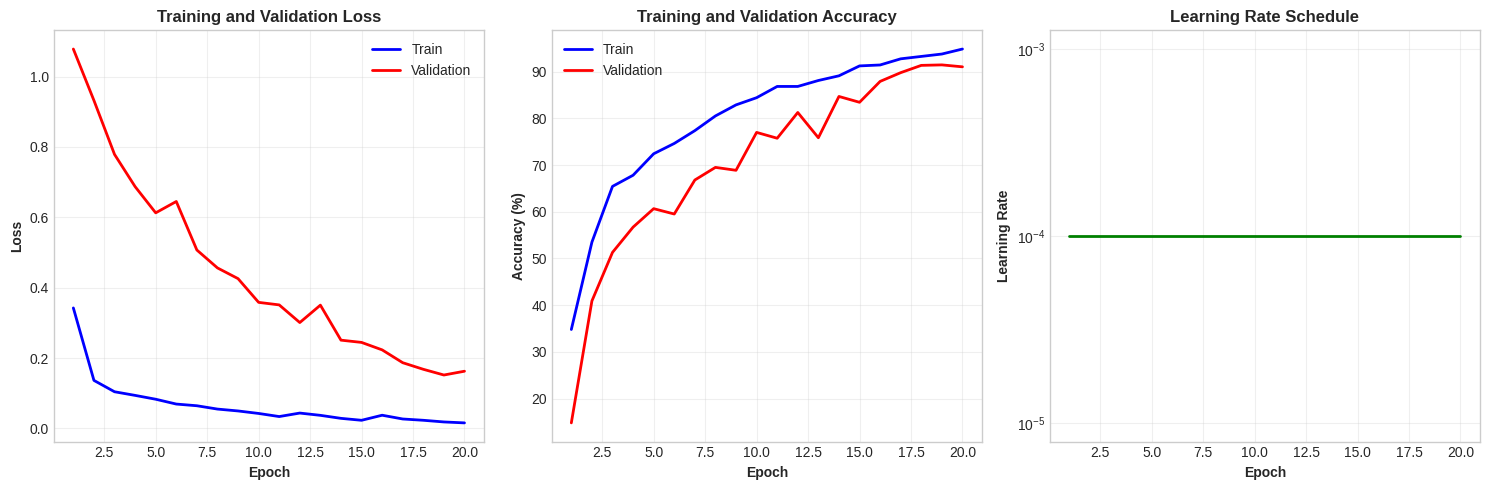

In [28]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontweight='bold')
axes[1].set_title('Training and Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(epochs, history['lr'], 'g-', linewidth=2)
axes[2].set_xlabel('Epoch', fontweight='bold')
axes[2].set_ylabel('Learning Rate', fontweight='bold')
axes[2].set_title('Learning Rate Schedule', fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../checkpoints/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Model Evaluation

In [29]:
# Load best model
checkpoint = torch.load(f'{config.SAVE_DIR}/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} (val_acc: {checkpoint['val_acc']:.2f}%)")

Loaded best model from epoch 19 (val_acc: 91.47%)


In [30]:
# Get predictions on test set
@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for images, labels in tqdm(loader, desc='Evaluating'):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

y_true, y_pred, y_prob = get_predictions(model, test_loader, DEVICE)

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

In [31]:
# Compute metrics
print("\n" + "="*60)
print("TEST SET EVALUATION METRICS")
print("="*60)

accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
recall = recall_score(y_true, y_pred, average='macro', zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100

print(f"\nOverall Metrics:")
print(f"  Accuracy:          {accuracy:.2f}%")
print(f"  Precision (macro): {precision:.2f}%")
print(f"  Recall (macro):    {recall:.2f}%")
print(f"  F1 Score (macro):  {f1:.2f}%")

# AUC
try:
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"  AUC (macro):       {auc:.2f}%")
except:
    auc = None

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=config.CLASS_NAMES))


TEST SET EVALUATION METRICS

Overall Metrics:
  Accuracy:          89.17%
  Precision (macro): 92.88%
  Recall (macro):    93.96%
  F1 Score (macro):  93.17%
  AUC (macro):       98.54%

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.96      0.99      0.98       134
ModerateDemented       1.00      1.00      1.00        10
     NonDemented       0.95      0.83      0.89       480
VeryMildDemented       0.80      0.93      0.86       336

        accuracy                           0.89       960
       macro avg       0.93      0.94      0.93       960
    weighted avg       0.90      0.89      0.89       960



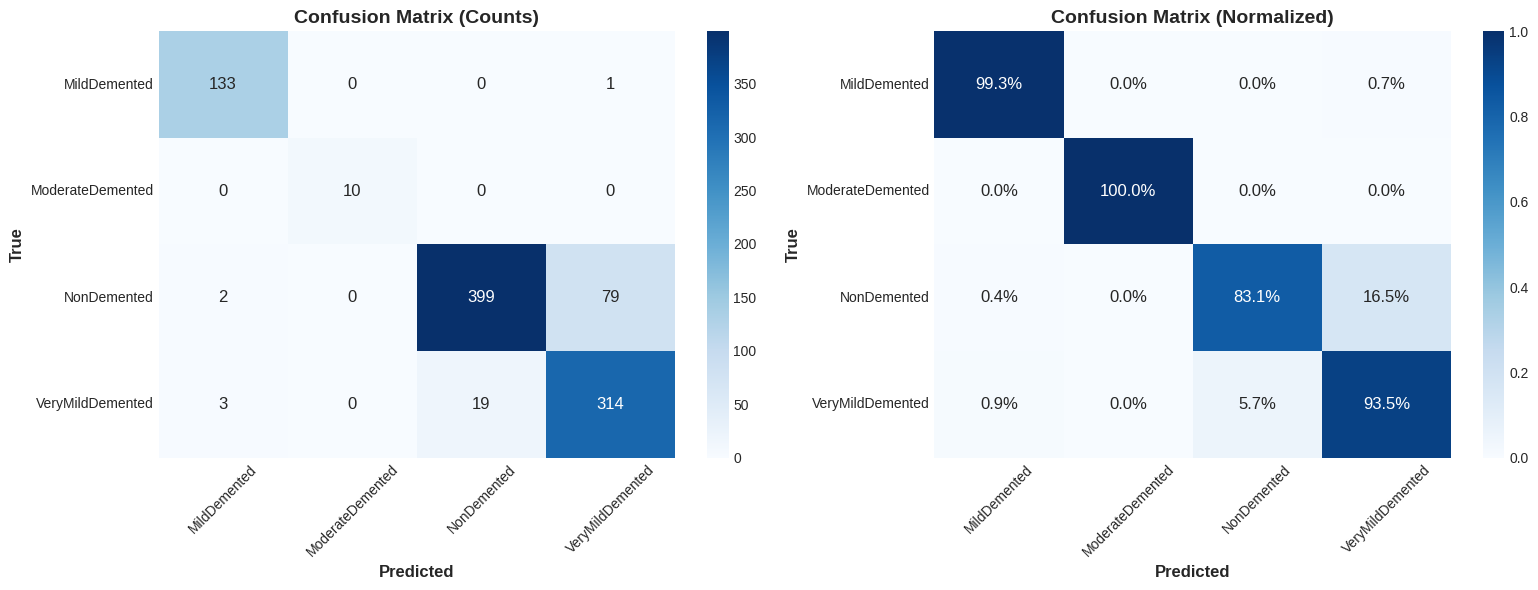

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=config.CLASS_NAMES, yticklabels=config.CLASS_NAMES,
            ax=axes[0], annot_kws={'size': 12})
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Blues',
            xticklabels=config.CLASS_NAMES, yticklabels=config.CLASS_NAMES,
            ax=axes[1], annot_kws={'size': 12})
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('../checkpoints/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Model Interpretability (Grad-CAM)

In [33]:
class GradCAM:
    """Grad-CAM implementation for model interpretability."""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients[0]
        activations = self.activations[0]

        weights = gradients.mean(dim=(1, 2), keepdim=True)
        cam = (weights * activations).sum(dim=0)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy()

# Get the last convolutional layer of EfficientNet
target_layer = model.backbone.features[-1]
gradcam = GradCAM(model, target_layer)

print("Grad-CAM initialized!")

Grad-CAM initialized!


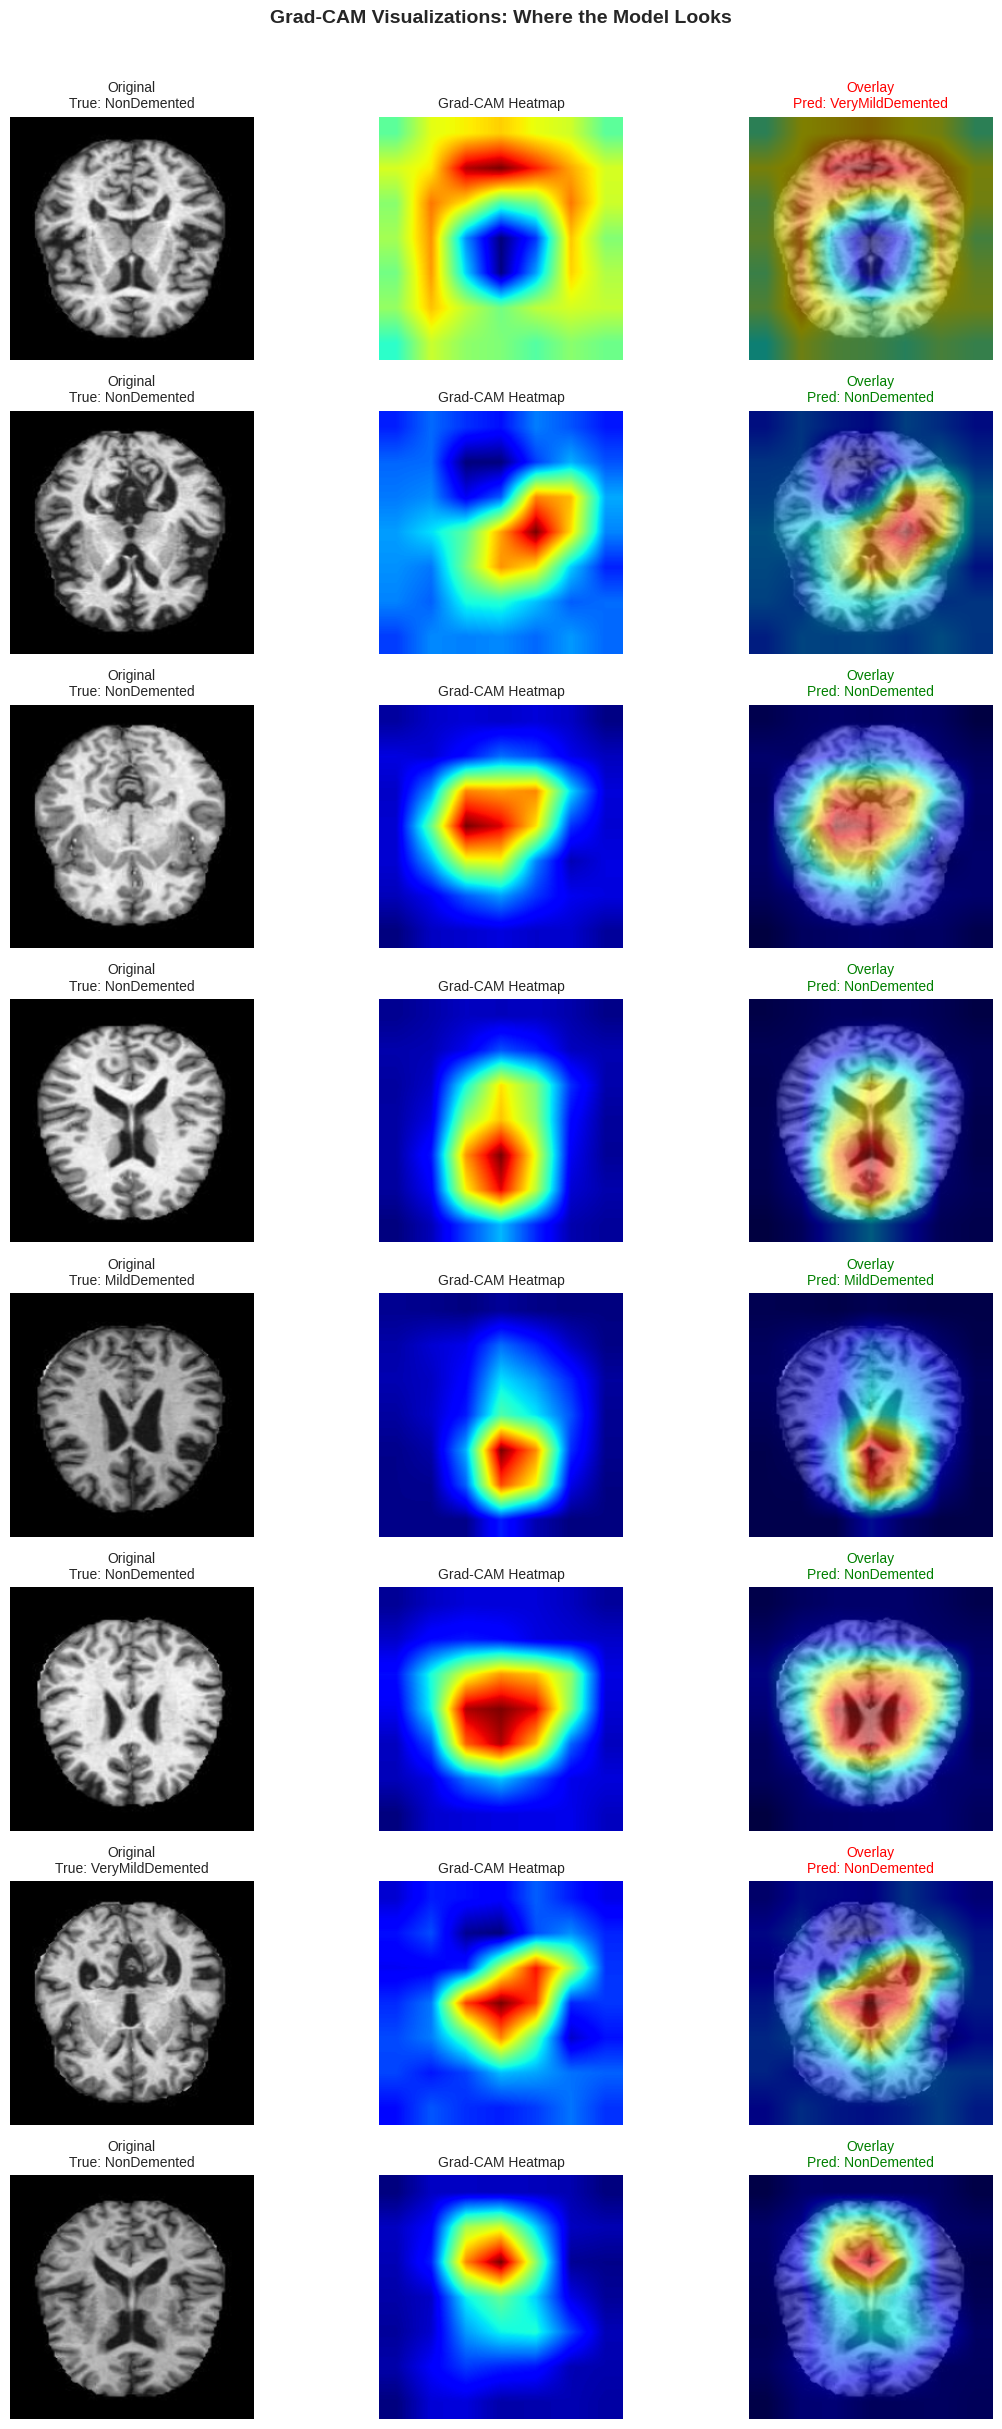

In [34]:
# Helper function to denormalize images
def denormalize(tensor):
    mean = np.array(MEAN)
    std = np.array(STD)
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# Visualize Grad-CAM for sample images
num_samples = 8
fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))

# Get sample images
sample_images = []
sample_labels = []
for images, labels in test_loader:
    for img, lbl in zip(images, labels):
        sample_images.append(img)
        sample_labels.append(lbl.item())
        if len(sample_images) >= num_samples:
            break
    if len(sample_images) >= num_samples:
        break

for i, (img, true_label) in enumerate(zip(sample_images, sample_labels)):
    img_tensor = img.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(img_tensor)
        pred_label = output.argmax(dim=1).item()

    # Generate Grad-CAM
    cam = gradcam.generate(img_tensor, pred_label)

    # Denormalize image
    original = denormalize(img)

    # Resize CAM
    cam_resized = cv2.resize(cam, (original.shape[1], original.shape[0]))

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    # Overlay
    overlay = 0.5 * original + 0.5 * heatmap
    overlay = overlay / overlay.max()

    # Plot
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f'Original\nTrue: {config.CLASS_NAMES[true_label]}', fontsize=10)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(cam_resized, cmap='jet')
    axes[i, 1].set_title('Grad-CAM Heatmap', fontsize=10)
    axes[i, 1].axis('off')

    color = 'green' if pred_label == true_label else 'red'
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Overlay\nPred: {config.CLASS_NAMES[pred_label]}', fontsize=10, color=color)
    axes[i, 2].axis('off')

plt.suptitle('Grad-CAM Visualizations: Where the Model Looks', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('../checkpoints/gradcam_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Sample Predictions Visualization

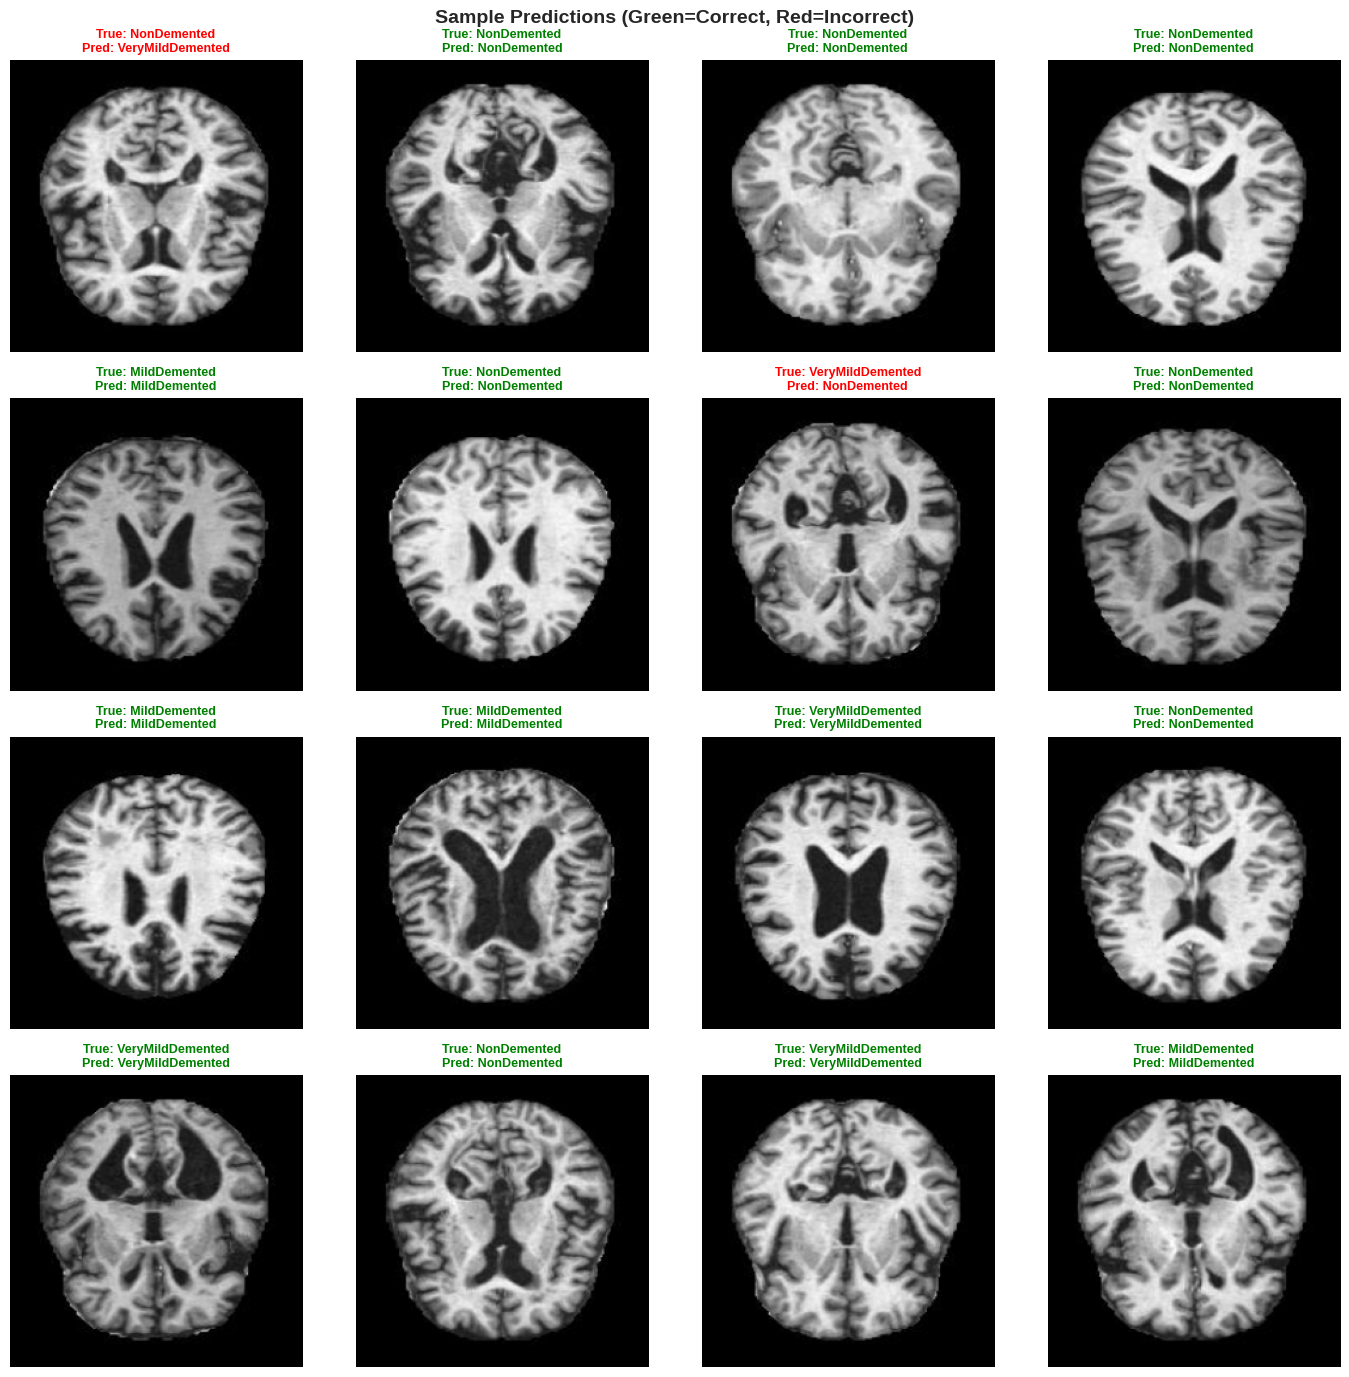

In [35]:
# Visualize predictions
num_samples = 16
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()

sample_images = []
sample_labels = []
sample_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = outputs.max(1)

        for img, lbl, pred in zip(images, labels, preds):
            sample_images.append(img.cpu())
            sample_labels.append(lbl.item())
            sample_preds.append(pred.item())

            if len(sample_images) >= num_samples:
                break
        if len(sample_images) >= num_samples:
            break

for i, (img, true_lbl, pred_lbl) in enumerate(zip(sample_images, sample_labels, sample_preds)):
    original = denormalize(img)
    axes[i].imshow(original)

    true_name = config.CLASS_NAMES[true_lbl]
    pred_name = config.CLASS_NAMES[pred_lbl]

    color = 'green' if true_lbl == pred_lbl else 'red'
    axes[i].set_title(f'True: {true_name}\nPred: {pred_name}', fontsize=9, color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../checkpoints/sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Model Card

In [36]:
model_card = f"""
================================================================================
                              MODEL CARD
================================================================================

MODEL DETAILS
--------------------------------------------------------------------------------
Name:                    Alzheimer's MRI Classification Model
Architecture:            EfficientNet-B0 (Transfer Learning)
Framework:               PyTorch {torch.__version__}
Total Parameters:        {total_params:,}
Trainable Parameters:    {trainable_params:,}

INTENDED USE
--------------------------------------------------------------------------------
Primary Use:             Research and educational purposes
                         Assisting in early detection of Alzheimer's disease
                         from brain MRI scans

Users:                   Researchers, medical students, healthcare professionals
                         (as a screening aid, NOT diagnostic tool)

Out of Scope:            Direct clinical diagnosis without expert verification
                         High-stakes medical decisions
                         Deployment in production healthcare systems

TRAINING DATA
--------------------------------------------------------------------------------
Dataset:                 Alzheimer's MRI 4-Classes Dataset
Total Images:            {len(image_paths)}
Classes:                 4 (NonDemented, VeryMildDemented, MildDemented, ModerateDemented)
Training Set:            {len(train_paths)} images
Validation Set:          {len(val_paths)} images
Test Set:                {len(test_paths)} images

PERFORMANCE METRICS (Test Set)
--------------------------------------------------------------------------------
Accuracy:                {accuracy:.2f}%
Precision (macro):       {precision:.2f}%
Recall (macro):          {recall:.2f}%
F1 Score (macro):        {f1:.2f}%
{f'AUC (macro):            {auc:.2f}%' if auc else ''}

LIMITATIONS AND BIASES
--------------------------------------------------------------------------------
1. Dataset Imbalance:    ModerateDemented class has very few samples (64),
                         which may affect model performance on this class.

2. Dataset Source:       Model trained on a specific dataset; may not
                         generalize well to MRI images from different
                         scanners, protocols, or populations.

3. 2D Slices Only:       Model analyzes individual 2D MRI slices, not
                         full 3D brain volumes, limiting anatomical context.

4. No Clinical Validation: This model has NOT been validated in clinical
                         settings and should NOT be used for diagnosis.

5. Demographic Bias:     Dataset demographics unknown; model may not
                         perform equally across all demographic groups.

ETHICAL CONSIDERATIONS
--------------------------------------------------------------------------------
- AI-assisted diagnosis should always be verified by qualified healthcare
  professionals
- False positives could cause unnecessary anxiety; false negatives could
  delay treatment
- Patient consent and data privacy must be maintained
- Model decisions should be explainable (Grad-CAM provided for transparency)

RECOMMENDATIONS
--------------------------------------------------------------------------------
1. Use as screening aid only, not as diagnostic tool
2. Always verify predictions with medical professionals
3. Fine-tune on local hospital data before any clinical use
4. Conduct thorough bias and fairness testing before deployment
5. Implement proper model monitoring in production

================================================================================
"""

print(model_card)

# Save model card
with open('../checkpoints/model_card.txt', 'w') as f:
    f.write(model_card)
print("Model card saved to ../checkpoints/model_card.txt")


                              MODEL CARD

MODEL DETAILS
--------------------------------------------------------------------------------
Name:                    Alzheimer's MRI Classification Model
Architecture:            EfficientNet-B0 (Transfer Learning)
Framework:               PyTorch 2.9.0+cu126
Total Parameters:        4,665,472
Trainable Parameters:    4,665,472

INTENDED USE
--------------------------------------------------------------------------------
Primary Use:             Research and educational purposes
                         Assisting in early detection of Alzheimer's disease
                         from brain MRI scans

Users:                   Researchers, medical students, healthcare professionals
                         (as a screening aid, NOT diagnostic tool)

Out of Scope:            Direct clinical diagnosis without expert verification
                         High-stakes medical decisions
                         Deployment in production healthcare sy

## 13. Summary and Conclusions

In [37]:
print("""
================================================================================
                         PROJECT SUMMARY
================================================================================

OBJECTIVE
--------------------------------------------------------------------------------
Built an AI model for early detection of Alzheimer's disease using brain MRI
scans, classifying images into 4 stages of dementia.

APPROACH
--------------------------------------------------------------------------------
1. Transfer Learning: Leveraged EfficientNet-B0 pre-trained on ImageNet
2. Data Augmentation: Applied rotation, flipping, and color jitter
3. Class Imbalance Handling: Used weighted loss and weighted sampling
4. Regularization: Dropout, early stopping, learning rate scheduling

KEY RESULTS
--------------------------------------------------------------------------------
""")
print(f"- Test Accuracy: {accuracy:.2f}%")
print(f"- F1 Score (macro): {f1:.2f}%")
print(f"- Best model saved at epoch with val_acc: {checkpoint['val_acc']:.2f}%")

print("""
DELIVERABLES
--------------------------------------------------------------------------------
1. ✓ Reproducible Jupyter Notebook (this file)
2. ✓ Trained Model (../checkpoints/best_model.pth)
3. ✓ Training History Plots
4. ✓ Confusion Matrix
5. ✓ Grad-CAM Visualizations (Model Interpretability)
6. ✓ Model Card (../checkpoints/model_card.txt)

FUTURE IMPROVEMENTS
--------------------------------------------------------------------------------
1. Collect more data for the underrepresented ModerateDemented class
2. Experiment with 3D convolutional networks for volumetric MRI
3. Implement ensemble methods for improved robustness
4. Add uncertainty quantification for clinical reliability
5. Validate on external datasets from different institutions

================================================================================
""")


                         PROJECT SUMMARY

OBJECTIVE
--------------------------------------------------------------------------------
Built an AI model for early detection of Alzheimer's disease using brain MRI
scans, classifying images into 4 stages of dementia.

APPROACH
--------------------------------------------------------------------------------
1. Transfer Learning: Leveraged EfficientNet-B0 pre-trained on ImageNet
2. Data Augmentation: Applied rotation, flipping, and color jitter
3. Class Imbalance Handling: Used weighted loss and weighted sampling
4. Regularization: Dropout, early stopping, learning rate scheduling

KEY RESULTS
--------------------------------------------------------------------------------

- Test Accuracy: 89.17%
- F1 Score (macro): 93.17%
- Best model saved at epoch with val_acc: 91.47%

DELIVERABLES
--------------------------------------------------------------------------------
1. ✓ Reproducible Jupyter Notebook (this file)
2. ✓ Trained Model (../checkpo

In [38]:
print("Notebook execution complete!")
print(f"\nAll outputs saved to: {config.SAVE_DIR}")
print("\nFiles generated:")
for f in os.listdir(config.SAVE_DIR):
    print(f"  - {f}")

Notebook execution complete!

All outputs saved to: /checkpoints

Files generated:
  - sample_predictions.png
  - class_distribution.png
  - training_history.png
  - sample_images.png
  - best_model.pth
  - model_card.txt
  - gradcam_visualizations.png
  - confusion_matrix.png


In [ ]:
from google.colab import drive
drive.mount('/content/drive')